# BRDF fitting and rendering

In this notebook, we will fit BRDFs to the processed images. The BRDFs will be rendered to check if they are faithful to the captured images and also quantiatively evaluated


In [25]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import torch
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ipywidgets import *
from torch import nn
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader
import scipy.optimize
import imageio.v2 as imageio



In [26]:
# Height & Width of the Grid
H, W = 256, 256
ball_radius = 60  # in mm  (Replace this with the size of your sphere)
light_dist = 1000 / ball_radius  # Distance of the light from the object.
camera_dist = 1850 / ball_radius  # Distance of the Camera from the object.

In [27]:
# Normalized Meshgrid with coordinates from -1 to 1. 
y, x = np.meshgrid(np.linspace(-1, 1, H), np.linspace(-1, 1, W))

# Mask for the pixels on the sphere considering it is a Unit Sphere (with a center at 0, 0 and a radius of 1)
in_frame = x**2 + y**2 <= 1

# Compute the z corresponding to each pixel. 
# Assume z is 0 in the center of the sphere and increases towards the camera
# z = sqrt(1 - x^2 - y^2) for points inside the sphere, else z = 0.
z = np.zeros_like(x)
z[in_frame] = np.sqrt(1 - x[in_frame]**2 - y[in_frame]**2)

# Compute the normals corresponding to each pixel for the unit sphere. 
# The normals are simply the normalized coordinates of the sphere surface.
normals = np.zeros((H, W, 3))
normals[..., 0] = x  # X-component
normals[..., 1] = y  # Y-component
normals[..., 2] = z  # Z-component
normals[in_frame] /= np.linalg.norm(normals[in_frame], axis=-1, keepdims=True)  # Normalize the vectors only for in-frame points

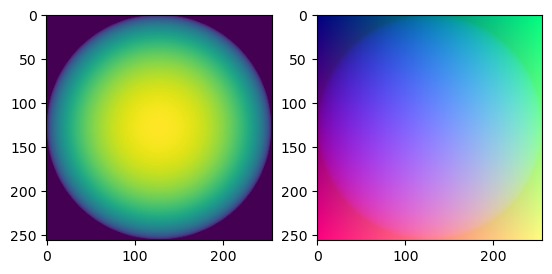

In [28]:
plt.subplot(1, 2, 1)
plt.imshow(z)
plt.subplot(1, 2, 2)
plt.imshow(normals / 2 + 0.5);

First, we define a simple BRDF model. Each BRDF instance should be callable, with two arguments: w_i, and w_o, which are the normalized vectors (omegas) describing the incident and and viewing directions respectively. The idea is to calculate the BRDF for all the points of the sphere at once (vectorized implementation) instead of finding the BRDF value for each point over a loop.

In [91]:
class LambertianBRDF:
    # Simple example for a Lambertian BRDF for virtual object (Green for instance)
    def __init__(self, diffuse_color=(0.0, 1.0, 0.0)):
        self.diffuse_color = np.array(diffuse_color)

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return np.broadcast_to(self.diffuse_color, w_i.shape)  # Broadcast is used to attend to the B x 3 expected shape of the directions

In [92]:
# Write the PhongBRDF in a similar format to the provided LambertianBRDF
class PhongBRDF:
    def __init__(self, diffuse_color=(0.0, 1.0, 0.0), specular_color=(1.0, 1.0, 1.0), alpha=20.0):
        self.diffuse_color = np.array(diffuse_color)
        self.specular_color = np.array(specular_color)
        self.alpha = alpha

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        # Calculate the halfway vector
        h = (w_i + w_o) / np.linalg.norm(w_i + w_o, axis=-1, keepdims=True)
        # Compute the diffuse term
        diffuse = np.broadcast_to(self.diffuse_color, w_i.shape)
        # Compute the specular term using the Phong reflection model
        specular = self.specular_color * (np.maximum(np.sum(h * w_o, axis=-1, keepdims=True), 0.0) ** self.alpha)
        # Return the combination of diffuse and specular components
        return diffuse + specular

In [93]:
# Utility function to normalize a vector
def normalize(v):
    """ Utility function that normalizes a vector. Expects shape ... x 3 """
    norm = np.linalg.norm(v, axis=-1, keepdims=True)
    return np.where(norm == 0, v, v / norm)  # Avoid division by zero by returning the original vector if norm is zero

In [96]:
#############################################################################################2nd
# Utility function to compute rotations
def get_rotations(a, b=(0.0, 0.0, 1.0)):
    """ Utility function that computes the rotation to bring a vector _a_ to direction _b_. 
        Hint: Keep in mind we are processing the points in parallel manner. That is, shape of vector a is B x 3    
    """
    a = normalize(a)
    b = normalize(np.array(b))
    v = np.cross(a, b)
    v_norm = np.linalg.norm(v, axis=-1, keepdims=True)
    skew = np.zeros((a.shape[0], 3, 3))
    skew[:, 0, 1] = -v[..., 2]
    skew[:, 0, 2] = v[..., 1]
    skew[:, 1, 0] = v[..., 2]
    skew[:, 1, 2] = -v[..., 0]
    skew[:, 2, 0] = -v[..., 1]
    skew[:, 2, 1] = v[..., 0]

        # Identity matrix for rotation matrix calculation
    i = np.eye(3).reshape(1, 3, 3)  # Shape: (1, 3, 3)
    i = np.broadcast_to(i, skew.shape)  # Shape: (B, 3, 3)
    # Cosine of the angle between `a` and `b`
    cos = np.einsum('ij,j->i', a, b)  # Dot product between `a` and `b`, shape (B,)


    # Rodrigues' rotation formula
    rotations = i + skew + np.matmul(skew, skew) * (1 / (1 + cos[:, np.newaxis, np.newaxis]))
    return rotations  # B x 3 x 3

In [98]:
###################################################################################################2
import numpy as np

def render_sphere_image(brdf, light_angle: float):
    """
    Returns the rendered sphere given a light direction.
    light_angle: float giving the light direction in degrees.
    """
    # Convert light angle to radians and compute light and camera positions
    light_angle = np.deg2rad(light_angle)
    light_pos = light_dist * np.array([0, np.sin(light_angle), np.cos(light_angle)])
    camera_pos = camera_dist * np.array([0, 0, 1])

    # Generate a grid of normalized coordinates for the unit sphere
    y, x = np.meshgrid(np.linspace(-1, 1, H), np.linspace(-1, 1, W))
    in_frame = x**2 + y**2 <= 1  # Mask for points within the unit sphere

    # Flatten x, y, and compute z values for the unit sphere
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = np.sqrt(1 - x_flat**2 - y_flat**2)
    z_flat[~in_frame.flatten()] = 0  # Set outside points to zero
    
    points = np.stack([x_flat, y_flat, z_flat], axis=-1)  # Shape: (B, 3)
    points = points[in_frame.flatten()]  # Only use points within the sphere

    # Normals at each point on the sphere's surface (same as points for a unit sphere)
    normals = points  # Shape: (B, 3)

    # Direction from each point to the light source
    dir_to_light = normalize(light_pos - points)  # Shape: (B, 3)

    # Direction from each point to the camera
    dir_to_camera = normalize(camera_pos - points)  # Shape: (B, 3)

    # Rotate directions into a canonical space using rotations that align each normal to the z-axis
    rotations = get_rotations(normals)  # Shape: (B, 3, 3)

    # Rotate `dir_to_light` and `dir_to_camera` to align with the canonical space
    w_i = np.einsum('bij,bj->bi', rotations, dir_to_light)  # Shape: (B, 3)
    w_o = np.einsum('bij,bj->bi', rotations, dir_to_camera)  # Shape: (B, 3)

    # Cosine term between the light direction and the normal at each point
    cos = np.einsum('bi,bi->b', dir_to_light, normals)[:, np.newaxis]  # Shape: (B, 1)
    cos = np.clip(cos, 0, 1)  # Ensure the cosine is non-negative

    # Evaluate the BRDF
    light_out = brdf(w_i, w_o) * cos  # Apply BRDF with cosine term for light attenuation

    # Reshape to the image format
    light_out_img = np.zeros((H * W, 3))  # Initialize with zero for all pixels
    light_out_img[in_frame.flatten()] = light_out  # Only assign to sphere pixels

    light_out_img = light_out_img.reshape(H, W, 3)  # Reshape to (H, W, 3) format
    light_out_img[~in_frame] = np.nan  # Set pixels outside the sphere to NaN

    return light_out_img


In [99]:
def linear_to_srgb(img):
	limit = 0.0031308
	return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

def plot_hdr(image, title=None):
    srgb = linear_to_srgb(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(np.clip(srgb, 0, 1))
    
def create_render(brdf):
    def render(light_angle):
        image = render_sphere_image(brdf, light_angle)
        plt.figure(figsize=(6, 6))
        plt.title("Rendered BRDF")
        plt.axis('off')
        plot_hdr(image)
    return render

In [100]:
brdf = PhongBRDF()
interact(create_render(brdf), brdf=brdf, light_angle=(-120, 120, 1.0));
# def render(brdf, light_angle):
#     image = render_sphere_image(brdf, light_angle)
#     plt.figure(figsize=(6, 6))
#     plt.title("Rendered BRDF")
#     plt.axis('off')
#     plot_hdr(image)
# interact(lambda light_angle: render(brdf, light_angle), light_angle=(-120, 120, 1.0))

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13600\3949108988.py:21: RuntimeWarning: invalid value encountered in sqrt
  z_flat = np.sqrt(1 - x_flat**2 - y_flat**2)


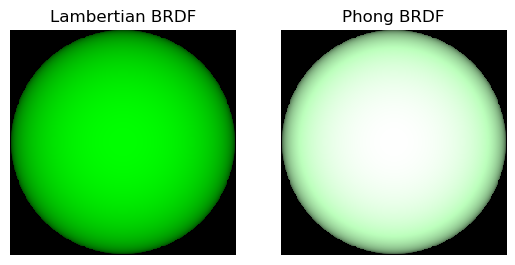

In [64]:
plt.subplot(1, 2, 1)
result = render_sphere_image(LambertianBRDF(), 0.0)
plot_hdr(result, "Lambertian BRDF")
plt.subplot(1, 2, 2)
result = render_sphere_image(PhongBRDF(), 0.0)
plot_hdr(result, "Phong BRDF")

## Load data
We defined and render static, manually adjusted BRDFs. Now will try to infere BRDFs from data.

In [65]:
# Loading paths
data_dir= Path("ru/HDR")
angles = [0, 5, 20, 35, 50, 65, 80, 95, 110, 135, 150, 165, 175] 
paths = [data_dir / "crops" / f"angle_{angle}.exr" for angle in angles]

assert len(paths) > 3 and all(p.exists() for p in paths)

hdr_crops = ... # Load and resize the (cropped) HDR images

In [66]:
hdr_crops = []

for path in paths:
    # Load the HDR image using OpenCV's imread function, which supports .exr files
    hdr_image = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    
    if hdr_image is None:
        raise ValueError(f"Could not load image at {path}")
    
    # Resize to a standard size if needed (e.g., 256x256)
    hdr_image_resized = cv2.resize(hdr_image, (256, 256), interpolation=cv2.INTER_LINEAR)
    
    # Add to list
    hdr_crops.append(hdr_image_resized)

# Convert list to numpy array for batch processing if desired
hdr_crops = np.stack(hdr_crops)  # Shape: (len(paths), 256, 256, 3) assuming RGB HDR images

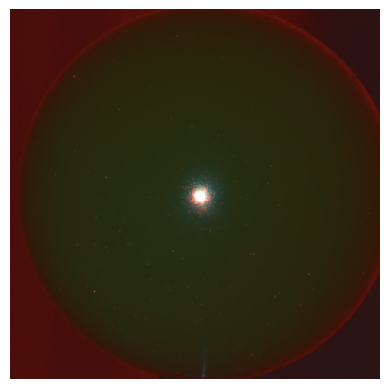

In [67]:
plot_hdr(hdr_crops[1])

In [68]:
def collect_brdf_data(input_image, light_angle=0.0, cos_eps=0.01):
    """
    Aggregates BRDF information from the input image, observing a certain light angle.
    Args:
        input_image: HDR image of the rendered sphere.
        light_angle: Float giving the light direction in degrees.
        cos_eps: Float threshold to ignore unreliable information (cos < cos_eps).
    Returns:
        Tuple of 3 np.arrays of shape (B, 3): w_i, w_o, and pixel_colors for valid pixels.
    """
    # Convert light angle to radians and determine the light position
    light_angle = np.deg2rad(light_angle)
    light_pos = light_dist * np.array([0, np.sin(light_angle), np.cos(light_angle)])
    camera_pos = camera_dist * np.array([0, 0, 1])

    # Flatten x, y, z coordinates to B x 3 format
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    points = np.stack([x_flat, y_flat, z_flat], axis=-1)  # Shape: (B, 3)
    points = points[in_frame.flatten()]  # Only points on the sphere surface

    # Surface normals are the same as points for a unit sphere centered at the origin
    normals = points  # Shape: (B_sphere, 3)

    # Direction to the light source
    dir_to_light = normalize(light_pos - points)  # Shape: (B_sphere, 3)

    # Direction to the camera
    dir_to_camera = normalize(camera_pos - points)  # Shape: (B_sphere, 3)

    # Calculate cosine of the angle between the normal and the light direction
    cos_theta = np.einsum('ij,ij->i', dir_to_light, normals)  # Shape: (B_sphere,)
    valid_mask = cos_theta >= cos_eps  # Only include pixels where cos_theta >= cos_eps

    # Apply the mask to filter valid points and directions
    w_i = dir_to_light[valid_mask]  # Incident directions for valid points
    w_o = dir_to_camera[valid_mask]  # Outgoing directions for valid points

    # Extract pixel colors from the input image
    input_image_flat = input_image.reshape(-1, 3)  # Flatten image to match point format
    pixel_colors = input_image_flat[in_frame.flatten()][valid_mask]  # Filter colors for valid points

    return w_i, w_o, pixel_colors


In [69]:
# Initialize lists to store results from each angle
w_i_list = []
w_o_list = []
values_list = []

# Iterate over each angle and corresponding HDR crop image
for angle, hdr_crop in zip(angles, hdr_crops):
    # Collect BRDF data for the current image and angle
    w_i_angle, w_o_angle, pixel_colors = collect_brdf_data(hdr_crop, light_angle=angle)

    # Append results to the lists
    w_i_list.append(w_i_angle)
    w_o_list.append(w_o_angle)
    values_list.append(pixel_colors)

# Concatenate results from all angles into single arrays
w_i = np.concatenate(w_i_list, axis=0)  # Shape: (total_valid_points, 3)
w_o = np.concatenate(w_o_list, axis=0)  # Shape: (total_valid_points, 3)
values = np.concatenate(values_list, axis=0)  # Shape: (total_valid_points, 3)


In [70]:
assert w_i.shape == w_o.shape == values.shape

In [71]:
class LambertianFitBRDF():
    def __init__(self):
        super().__init__()
        self.model = LambertianBRDF()
        self.params = np.array(self.model.diffuse_color)
        self.result = None
    
    def run(self, params, w_i, w_o):
        self.model.diffuse_color = params[:3]
        return self.model(w_i, w_o)

    def objective(self, params, w_i, w_o, values):
        prediction = self.run(params, w_i, w_o)
        return np.mean((prediction - values) ** 2)

    def fit(self, w_i, w_o, values):
        self.result = scipy.optimize.minimize(self.objective, x0=self.params, args=(w_i, w_o, values))
        self.params = self.result.x
        return self

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return self.run(self.params, w_i, w_o)

In [72]:
fitted_brdf = LambertianFitBRDF().fit(w_i, w_o, values)

In [73]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13600\3949108988.py:21: RuntimeWarning: invalid value encountered in sqrt
  z_flat = np.sqrt(1 - x_flat**2 - y_flat**2)


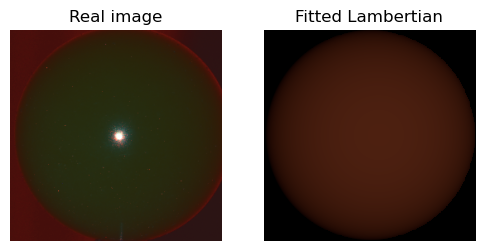

In [74]:
idx = 1
plt.figure(figsize=(6, 12))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Lambertian");

Similar to the LambertianFitBRDF, you are required to provide the code for the methods of the PhongFitBRDF

In [75]:
from scipy.optimize import minimize


class PhongFitBRDF:
    def __init__(self):
        # Initialize BRDF parameters: diffuse color (R, G, B), specular color (R, G, B), and shininess (alpha)
        self.diffuse_color = np.array([0.5, 0.5, 0.5])  # Initial diffuse color
        self.specular_color = np.array([0.5, 0.5, 0.5])  # Initial specular color
        self.alpha = 20.0  # Initial shininess coefficient

    def run(self, params, w_i, w_o):
        """
        Calculate the Phong BRDF with the current parameters.
        Args:
            params: Array containing diffuse color (3), specular color (3), and alpha (1).
            w_i: Array of incident directions.
            w_o: Array of outgoing directions.
        Returns:
            Calculated BRDF values based on input directions and params.
        """
        # Unpack params
        diffuse_color = params[:3]
        specular_color = params[3:6]
        alpha = params[6]

        # Calculate halfway vector
        h = normalize((w_i + w_o) / 2)

        # Diffuse component (Lambertian reflection)
        diffuse = np.broadcast_to(diffuse_color, w_i.shape)

        # Specular component (Phong reflection)
        # Use a normal vector [0, 0, 1] broadcasted to match the shape of `h`
        normal = np.array([0, 0, 1]).reshape(1, 3)
        specular_term = np.maximum(np.einsum('ij,ij->i', h, normal), 0.0) ** alpha
        specular = specular_color * specular_term[:, np.newaxis]

        # Total BRDF
        return diffuse + specular

    def objective(self, params, w_i, w_o, values):
        """
        Objective function to minimize. Computes the mean squared error between
        the predicted BRDF values and actual observed values.
        Args:
            params: Array of current BRDF parameters.
            w_i: Array of incident directions.
            w_o: Array of outgoing directions.
            values: Observed BRDF values.
        Returns:
            Mean squared error between predicted and observed BRDF values.
        """
        predictions = self.run(params, w_i, w_o)
        error = np.mean((predictions - values) ** 2)
        return error

    def fit(self, w_i, w_o, values):
        """
        Fit the Phong BRDF model to observed BRDF values.
        Args:
            w_i: Array of incident directions.
            w_o: Array of outgoing directions.
            values: Observed BRDF values.
        """
        # Initial parameters: [diffuse_color, specular_color, alpha]
        initial_params = np.concatenate([self.diffuse_color, self.specular_color, [self.alpha]])

        # Bounds: diffuse and specular colors between [0, 1], alpha between [1, 100]
        bounds = [(0, 1)] * 6 + [(1, 100)]

        # Minimize the objective function
        result = minimize(self.objective, initial_params, args=(w_i, w_o, values), bounds=bounds)

        # Update parameters if optimization is successful
        if result.success:
            self.diffuse_color = result.x[:3]
            self.specular_color = result.x[3:6]
            self.alpha = result.x[6]
        else:
            raise RuntimeError("Optimization failed: " + result.message)

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        """
        Compute the BRDF for given directions with the optimized parameters.
        Args:
            w_i: Incident directions.
            w_o: Outgoing directions.
        Returns:
            Predicted BRDF values based on the optimized parameters.
        """
        # Concatenate current parameters
        params = np.concatenate([self.diffuse_color, self.specular_color, [self.alpha]])
        return self.run(params, w_i, w_o)


In [76]:
#fitted_brdf = PhongFitBRDF().fit(w_i, w_o, values)
fitted_brdf = PhongFitBRDF()
fitted_brdf.fit(w_i, w_o, values)

In [77]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13600\3949108988.py:21: RuntimeWarning: invalid value encountered in sqrt
  z_flat = np.sqrt(1 - x_flat**2 - y_flat**2)


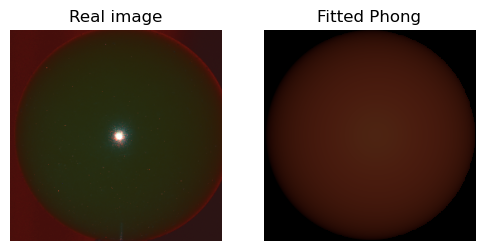

In [78]:
idx = 1
plt.figure(figsize=(6, 12))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Phong");

While the Phong model fits the data significantly better, it still has several limitations.
In this section we will model the BRDF directly using a neural network following the approach proposed by Sztrajman et al. in https://arxiv.org/pdf/2102.05963.pdf 

In [79]:
def default_transform(w_i, w_o):
    return np.concatenate([w_i, w_o], axis=1)

In [84]:
def to_rusinkiewicz(w_i, w_o):
    """
    Converts incident and outgoing directions to the Rusinkiewicz parameterization.
    Args:
        w_i: Incident direction vector (shape: B x 3).
        w_o: Outgoing direction vector (shape: B x 3).
    Returns:
        Tuple of np.ndarrays (theta_h, phi_h, theta_d, phi_d) each of shape (B,).
    """
    w_i = normalize(w_i)
    w_o = normalize(w_o)
    h = normalize((w_i + w_o) / 2)

    theta_h = np.arccos(np.clip(h[:, 2], -1.0, 1.0))  # Angle between h and z-axis
    phi_h = np.arctan2(h[:, 1], h[:, 0])              # Azimuthal angle of h
    theta_d = np.arccos(np.clip(np.einsum('ij,ij->i', w_i, h), -1.0, 1.0))
    phi_d = np.arctan2(
        np.einsum('ij,ij->i', np.cross(normalize(w_i - h * np.einsum('ij,ij->i', w_i, h)[:, None]), 
                                       normalize(w_o - h * np.einsum('ij,ij->i', w_o, h)[:, None])), h),
        np.einsum('ij,ij->i', normalize(w_i - h * np.einsum('ij,ij->i', w_i, h)[:, None]), 
                          normalize(w_o - h * np.einsum('ij,ij->i', w_o, h)[:, None]))
    )

    # Additional features to get a 6-dimensional feature vector
    cos_theta_h = np.cos(theta_h)
    cos_theta_d = np.cos(theta_d)

    return np.column_stack((theta_h, phi_h, theta_d, phi_d, cos_theta_h, cos_theta_d))


In [85]:
class IndicesDataset(torch.utils.data.Dataset):
    """ Utility class for random batching """
    def __init__(self, tensor):
        super(IndicesDataset, self).__init__()
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, item):
        return self.tensor[item]

In [86]:
class IndicesDataset(Dataset):
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.indices[idx]

class NeuralBRDF(nn.Module):
    def __init__(self, device='cpu', input_size=6, transform=default_transform):
        super(NeuralBRDF, self).__init__()
        self.device = device
        self.transform = transform
        
        # Define a simple MLP with 3 hidden layers and ReLU activations
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Output layer with 3 channels (RGB)
        ).to(device)

    def forward(self, data):
        # Run the data through the model + the final exponential activation
        return torch.exp(self.model(data))

    def _train(self, data, values, weights, epochs):
        # Expand weights to match the shape of values
        weights = weights[:, None].expand_as(values)
        
        # Define optimizer and loss function (mean squared error)
        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        criterion = nn.MSELoss(reduction='none')  # Apply weighted MSELoss

        # Define DataLoader for mini-batch training
        indices = IndicesDataset(torch.arange(0, len(data), device=data.device))
        data_loader = DataLoader(indices, batch_size=2000, shuffle=True)

        for _ in range(epochs):
            for chunk in data_loader:
                # Get mini-batch data
                batch_data = data[chunk]
                batch_values = values[chunk]
                batch_weights = weights[chunk]

                # Forward pass
                predictions = self.forward(batch_data)
                
                # Compute loss with weights
                loss = (batch_weights * criterion(predictions, batch_values)).mean()

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    def fit(self, w_i, w_o, values, epochs=40):
        # Transform input directions using the provided transform
        data = self.transform(w_i, w_o)

        # Ensure data is a single numpy array before converting to a tensor
        data = np.array(data, dtype=np.float32)  # Convert to numpy array

        # Calculate weights as l · n (dot product of w_i and normal vector)
        l_dot_n = torch.tensor(np.clip(w_i[..., 2], 1e-5, 1), dtype=torch.float32, device=self.device)

        # Convert data and values to tensors
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        values = torch.tensor(values, dtype=torch.float32, device=self.device)

        # Train the model
        self._train(data, values, l_dot_n, epochs)
        return self

    def inference(self, data):
        # Run data through the model in evaluation mode
        self.eval()
        with torch.no_grad():
            predicted = self.forward(data)
        return predicted.cpu().numpy()

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        # Apply the transform to prepare data for inference
        data = self.transform(w_i, w_o)
        
        # Ensure data is a single numpy array before converting to a tensor
        data = np.array(data, dtype=np.float32)

        # Convert data to a tensor and handle NaN or infinite values
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        data[~torch.isfinite(data)] = 0
        
        # Perform inference
        return self.inference(data)


In [87]:
fitted_brdf = NeuralBRDF(input_size=6, transform=to_rusinkiewicz).fit(w_i, w_o, values)

In [88]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13600\3949108988.py:21: RuntimeWarning: invalid value encountered in sqrt
  z_flat = np.sqrt(1 - x_flat**2 - y_flat**2)


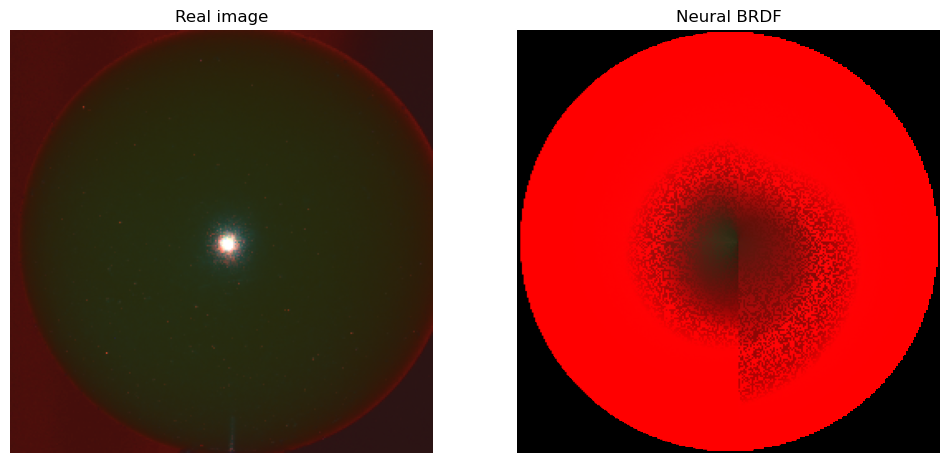

In [89]:
idx = 1
plt.figure(figsize=(12, 24))
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real image")
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Neural BRDF");

In this section you should evaluate the rendered images, comparing them to the camera captures.
Visualize and compute metrics for the Phong and Neural fitted BRDFs.

In [90]:
mse = 0
ssim = 0

As the last task describe in text your observations regarding:
* How do the Phong and Neural BRDFs compare visually and in terms of metrics.
* How do the two (or more) captured spheres compare. To work with the second material you can duplicate the fitting cells in this notebook or create another notebook for it.
* Optionally, you can describe the effect of using different parametrizations, architectures, and loss functions for Neural BRDFs.